In [1]:
!pip install antlr4-python3-runtime==4.9.3
!pip install pycocotools==2.0.2
!pip install /kaggle/input/effdet-030-package-dataset/packages/huggingface_hub-0.13.3-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=470690372d3b12d12415eb3bb4a92e08b9b622af05bfb54fbba1c2ec5e25700a
  Stored in directory: /root/.cache/pip/wheels/a9/8b/1f/b8233836d5798e3224c2442947e9639f220095de8bf46e800c
Successfully built antlr4-python3-runtime
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=371339 sha256=ae5cc1299e3efe9b1bb7d449109ec5d6b339d699a2903128c69ab248a89a76c9
  Stored in directory: /root/.cache/pip/wheels/b9/f8/1f/7b70e01d2edb27c559ef78748a3a271d8ce5b42ccc6b291a7d
Successfully built pycocotools
Processing /kaggle/input/effdet-030-package-dataset/packages/huggingface_hub-0.13.3-py3-none-any.whl
huggingface-hub is already installed with the same version as the provided wheel. Use --force-

In [2]:
!cp /kaggle/input/pydicom-conda-helper/*.bz2 /kaggle/working/

!conda install --offline 'libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -y
!conda install --offline 'libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -y
!conda install --offline 'gdcm-2.8.9-py37h500ead1_1.tar.bz2' -y
!conda install --offline 'conda-4.10.1-py37h89c1867_0.tar.bz2' -c conda-forge -y
!conda install --offline 'certifi-2020.12.5-py37h89c1867_1.tar.bz2' -y
!conda install --offline 'openssl-1.1.1k-h7f98852_0.tar.bz2' -y


######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [3]:
import sys
sys.path.insert(0, "../input/effdet-030-package-dataset/packages/")
import os
import ast

# Basic libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Draw a sample
import matplotlib.pyplot as pp
import matplotlib.patches as patches
%matplotlib inline

# Make data
from PIL import Image, ImageDraw
import pydicom
import cv2

# Model and training
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader, default_collate
from torchvision.transforms.functional import to_pil_image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from effdet import EfficientDet, DetBenchTrain, get_efficientdet_config, DetBenchPredict

In [4]:
### Get train image list with bounding boxes
train_image_list = pd.read_csv('/kaggle/input/siim-covid19-detection/train_image_level.csv')
train_image_list = train_image_list.drop(columns=['label'])
train_image_list = train_image_list.rename(columns={'id':'imageID', 'StudyInstanceUID':'studyID'})
train_image_list = train_image_list.assign(seriesID=pd.Series(dtype=str))
train_image_list = train_image_list.reindex(columns=['studyID', 'seriesID', 'imageID', 'boxes'])

train_root_path = '/kaggle/input/siim-covid19-detection/train'
for i in tqdm(range(len(train_image_list))):
    top_dir = os.path.join(train_root_path, train_image_list.loc[i].studyID)
    file_name = train_image_list.loc[i].imageID.split('_')[0] + '.dcm'
    middle_dir = ''
    for d in os.listdir(top_dir):
        file_path = os.path.join(top_dir, d, file_name)
        if os.path.isfile(file_path):
            middle_dir = d
            break
    train_image_list.loc[i].imageID = file_name
    train_image_list.loc[i].seriesID = middle_dir

train_image_list = train_image_list.dropna(subset=['boxes']).reset_index()

  0%|          | 0/6334 [00:00<?, ?it/s]

In [5]:
train_class_db = pd.read_csv('/kaggle/input/siim-covid19-detection/train_study_level.csv')
train_class_db = train_class_db.rename(columns={
    'id':'studyID',
    'Negative for Pneumonia':'negative',
    'Typical Appearance':'typical',
    'Indeterminate Appearance':'indeterminate',
    'Atypical Appearance':'atypical'})

In [6]:
train_image_list = train_image_list.assign(classID=pd.Series(dtype=int))
for i in range(len(train_image_list)):
    studyID = train_image_list.loc[i]['studyID'] + '_study'
    idx_loc = train_class_db[train_class_db['studyID']==studyID].index.item()
    if train_class_db.loc[idx_loc].negative == 1:
        train_image_list.loc[i,'classID'] = int(-1)
    elif train_class_db.loc[idx_loc].typical == 1:
        train_image_list.loc[i,'classID'] = int(1)
    elif train_class_db.loc[idx_loc].indeterminate == 1:
        train_image_list.loc[i,'classID'] = int(2)
    elif train_class_db.loc[idx_loc].atypical == 1:
        train_image_list.loc[i,'classID'] = int(3)

In [7]:
class CTDataset(Dataset):
    def __init__(self, train_root_path, train_image_list, image_size=512):
        self.train_image_path = train_root_path
        self.train_image_list = train_image_list
        self.image_size = image_size
        self.albu_no_label = A.Compose([
            A.Resize(width=self.image_size, height=self.image_size, p=1),
            ToTensorV2()
        ])
        self.albu = A.Compose([
            A.Resize(width=self.image_size, height=self.image_size, p=1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    
    def __len__(self):
        return len(self.train_image_list)
        #return 12
    
    def __getitem__(self, idx):
        # Image
        loc = self.train_image_list.loc[idx]
        top_path = loc.studyID
        middle_path = loc.seriesID
        file_name = loc.imageID
        
        dcm_path = os.path.join(self.train_image_path, top_path, middle_path, file_name)
        dcm = pydicom.dcmread(dcm_path)
        image = dcm.pixel_array.astype("float32")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # bounding boxes
        boxes_str = train_image_list.loc[idx].boxes
        class_id = train_image_list.loc[idx].classID
        
        bboxes, labels = self._get_bounding_boxes(boxes_str, class_id)
        
        if bboxes.shape[0] == 0:
            result = self.albu_no_label(image=image)
            x = result['image']
            bboxes = torch.zeros([1, 4], dtype=torch.float32)
            labels = torch.FloatTensor(np.array([0]))
        else:
            result = self.albu(
                image = np.array(image),
                bboxes = bboxes,
                labels = labels
            )
            x = result['image']
            box = np.array(result['bboxes'])[:,[1,0,3,2]] # from xyxy to yxyx
            bboxes = torch.FloatTensor(box)
            labels = torch.FloatTensor(np.array(result['labels']))

        y = {
            'bbox': bboxes,
            'cls': labels
        }
        
        return x, y
    
    
    def _get_bounding_boxes(self, boxes_str, class_id):
        boxes = []
        labels = []
        
        if isinstance(boxes_str, str) == False:
            return np.array(boxes), np.array(labels)
        
        bounding_boxes = ast.literal_eval(boxes_str)
        
        for bounding_box in bounding_boxes:
            x0 = max(0, int(round(bounding_box['x'])))
            y0 = max(0, int(round(bounding_box['y'])))
            x1 = max(0, x0 + int(round(bounding_box['width'])))
            y1 = max(0, y0 + int(round(bounding_box['height'])))
            box = [x0, y0, x1, y1]
            boxes.append(box)
            labels.append(np.array([class_id]).astype(int))

        boxes = np.array(boxes)
        labels = np.array(labels)

        return boxes, labels

In [8]:
import torch.nn.functional as F

def pad_collate_fn(batch):
    shapes = [item[1]['bbox'].shape[0] for item in batch]
    max_shape = max(shapes)
    
    padded_batch = []
    for x, y in batch:
        if any(elem == 0 for elem in y['cls']):
            continue
        pad_size = max_shape - y['bbox'].shape[0]
        bbox_padding = [0, 0, 0, pad_size]
        cls_padding = [0, 0, 0, pad_size]
        padded_y = {
            'bbox': F.pad(y['bbox'], bbox_padding, mode='constant', value=0),
            'cls': F.pad(y['cls'].reshape((y['cls'].shape[0],1)), cls_padding, mode='constant', value=0)
        }
        padded_batch.append((x, padded_y))
    
    return default_collate(padded_batch)

In [9]:
dataset = CTDataset(train_root_path, train_image_list)
loader = DataLoader(
    dataset, batch_size=4, num_workers=2, collate_fn=pad_collate_fn
)

n_epochs = 1
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cfg = get_efficientdet_config(f'tf_efficientdet_d0')
cfg.num_classes = 3
model = EfficientDet(cfg)
bench = DetBenchTrain(model)#.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

print('Starting training')
for epoch in range(1, n_epochs+1):
    header = f'[{epoch}/{n_epochs}]'
    
    lr = optimizer.param_groups[0]['lr']
    print(f'{header}Starting lr={lr:7f}')
    
    metrics = {
        'loss': []
    }
    t = tqdm(loader, leave=False)
    
    for inputs, targets in t:
        #inputs = inputs.to(device)
        #targets['bbox'] = targets['bbox'].to(device)
        #targets['cls'] = targets['cls'].to(device)
        
        optimizer.zero_grad()
        losses = bench(inputs, targets)
        loss = losses['loss']
        loss.backward()
        optimizer.step()
        iter_metrics = {
            'loss': float(loss.item())
        }
        message = ' '.join([f'{k}:{v:4f}' for k, v in iter_metrics.items()])
        t.set_description(f'{header}{message}')
        t.refresh()
        for k, v in iter_metrics.items():
            metrics[k].append(v)
        train_metrics = {k:np.mean(v) for k, v in metrics.items()}
        train_message = ' '.join([f'{k}:{v:4f}' for k, v in train_metrics.items()])
        print(f'{header}Train: {train_message}')
        
    if epoch % 10 == 0:
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict()
        }
        checkpoint_dir = f'weights/b0'
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        checkpoint_path = os.path.join(checkpoint_dir, f'{epoch}.pth')
        torch.save(state, checkpoint_path)
        print(f'{header}Saved "{checkpoint_path}"')
    
    scheduler.step(train_metrics['loss'])
    print()


state = {
    'epoch': epoch,
    'state_dict': model.state_dict()
}
checkpoint_dir = f'weights/b0'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, f'end_{epoch}.pth')
torch.save(state, checkpoint_path)
print(f'{header}Saved "{checkpoint_path}"')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


Starting training
[1/1]Starting lr=0.000100


  0%|          | 0/1074 [00:00<?, ?it/s]

[1/1]Train: loss:3.766310
[1/1]Train: loss:3.907516
[1/1]Train: loss:4.936051
[1/1]Train: loss:4.770727
[1/1]Train: loss:4.626458
[1/1]Train: loss:4.596625
[1/1]Train: loss:4.490837
[1/1]Train: loss:4.564761
[1/1]Train: loss:4.573684
[1/1]Train: loss:4.415190
[1/1]Train: loss:4.408471
[1/1]Train: loss:4.367970
[1/1]Train: loss:4.324714
[1/1]Train: loss:4.547158
[1/1]Train: loss:4.506219
[1/1]Train: loss:4.430466
[1/1]Train: loss:4.364639
[1/1]Train: loss:4.371958
[1/1]Train: loss:4.340812
[1/1]Train: loss:4.298400
[1/1]Train: loss:4.263455
[1/1]Train: loss:4.238833
[1/1]Train: loss:4.211381
[1/1]Train: loss:4.245729
[1/1]Train: loss:4.242912
[1/1]Train: loss:4.213518
[1/1]Train: loss:4.215635
[1/1]Train: loss:4.161321
[1/1]Train: loss:4.133534
[1/1]Train: loss:4.110593
[1/1]Train: loss:4.096786
[1/1]Train: loss:4.062054
[1/1]Train: loss:4.029509
[1/1]Train: loss:4.000613
[1/1]Train: loss:3.971351
[1/1]Train: loss:3.948099
[1/1]Train: loss:3.952803
[1/1]Train: loss:3.921756
[1/1]Train: 

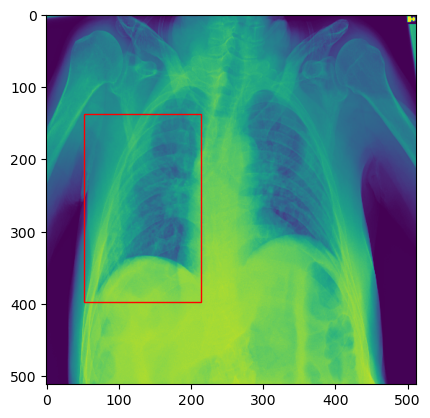

In [28]:
num = 0
image, targets = dataset.__getitem__(num)
image = image.unsqueeze(0)

bench = DetBenchPredict(model)
with torch.no_grad():
    output = bench(image)

fig, ax = pp.subplots()
ax.imshow(image[0,0,:,:])

for i in range(output.shape[1]):
    if output[0,i,4]>0.35:
        x1 = int(output[0, i, 0])
        y1 = int(output[0, i, 1])
        width = int(output[0, i, 2] - output[0, i, 0])
        height = int(output[0, i, 3] - output[0, i, 1])
        rect = patches.Rectangle((x1, y1), width, height, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
pp.show()

In [24]:
output[0,0:5,:]

tensor([[5.2586e+01, 1.3779e+02, 2.1469e+02, 3.9832e+02, 4.7429e-01, 1.0000e+00],
        [8.6156e+01, 1.9560e+02, 1.8981e+02, 3.8612e+02, 3.3589e-01, 1.0000e+00],
        [5.9774e+01, 1.8248e+02, 1.6658e+02, 3.4873e+02, 2.9530e-01, 1.0000e+00],
        [2.8768e+02, 1.0552e+02, 4.2607e+02, 3.5581e+02, 2.9471e-01, 1.0000e+00],
        [6.6105e+01, 1.0562e+02, 1.9994e+02, 3.8293e+02, 2.8977e-01, 2.0000e+00]])

In [12]:
train_image_list.loc[num]['boxes'], train_image_list.loc[num]['classID']

("[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",
 1.0)

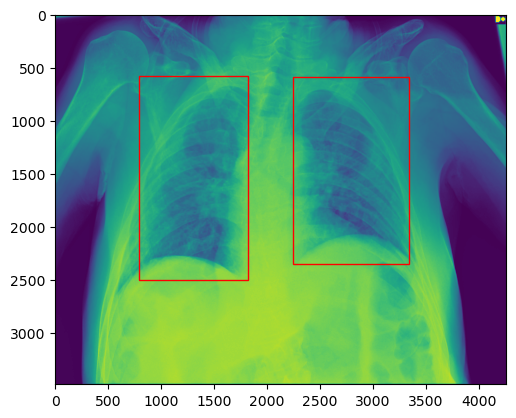

(3488, 4256)

In [14]:
dcm_path = os.path.join(train_root_path,
                        train_image_list['studyID'][num],
                        train_image_list['seriesID'][num],
                        train_image_list['imageID'][num])
dcm = pydicom.dcmread(dcm_path)
image = dcm.pixel_array.astype("float32")

fig, ax = pp.subplots()
ax.imshow(image)

x0 = 789
y0 = 582
width = 1026
height = 1917
rect = patches.Rectangle((x0, y0), width, height, edgecolor='r', facecolor='none')
ax.add_patch(rect)

x0 = 2245
y0 = 591
width = 1094
height = 1761
rect = patches.Rectangle((x0, y0), width, height, edgecolor='r', facecolor='none')
ax.add_patch(rect)

pp.show()
image.shape

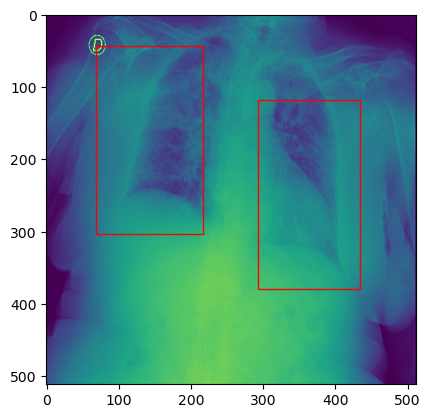

In [29]:
num = 1
image, targets = dataset.__getitem__(num)
image = image.unsqueeze(0)

bench = DetBenchPredict(model)
with torch.no_grad():
    output = bench(image)

fig, ax = pp.subplots()
ax.imshow(image[0,0,:,:])

for i in range(output.shape[1]):
    if output[0,i,4]>0.35:
        x1 = int(output[0, i, 0])
        y1 = int(output[0, i, 1])
        width = int(output[0, i, 2] - output[0, i, 0])
        height = int(output[0, i, 3] - output[0, i, 1])
        rect = patches.Rectangle((x1, y1), width, height, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
pp.show()

In [30]:
output[0,0:5,:]

tensor([[2.9318e+02, 1.1888e+02, 4.3491e+02, 3.8043e+02, 4.5129e-01, 1.0000e+00],
        [6.8702e+01, 4.3699e+01, 2.1843e+02, 3.0375e+02, 4.3970e-01, 1.0000e+00],
        [1.2401e+02, 1.3095e+02, 2.2208e+02, 2.6028e+02, 3.3446e-01, 1.0000e+00],
        [3.1982e+02, 1.9969e+02, 4.3309e+02, 3.5459e+02, 3.3203e-01, 1.0000e+00],
        [8.9540e+01, 1.2651e+02, 2.1669e+02, 3.5871e+02, 3.0463e-01, 1.0000e+00]])

In [31]:
train_image_list.loc[num]['boxes'], train_image_list.loc[num]['classID']

("[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",
 1.0)

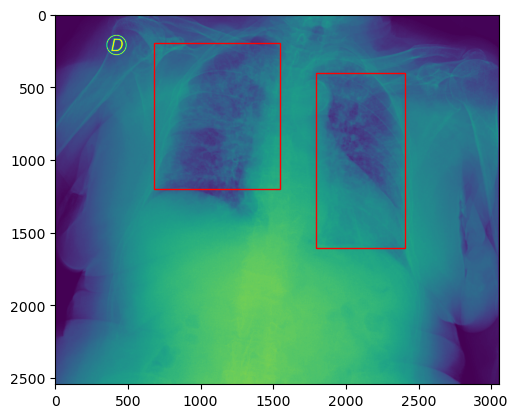

(2544, 3056)

In [33]:
dcm_path = os.path.join(train_root_path,
                        train_image_list['studyID'][num],
                        train_image_list['seriesID'][num],
                        train_image_list['imageID'][num])
dcm = pydicom.dcmread(dcm_path)
image = dcm.pixel_array.astype("float32")

fig, ax = pp.subplots()
ax.imshow(image)

c = np.array([[677, 197, 867, 999], [1792, 402, 617, 1204]])

for i in range(c.shape[0]):
    x1 = c[i,0]
    y1 = c[i,1]
    width = c[i,2]
    height = c[i,3]
    rect = patches.Rectangle((x1, y1), width, height, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

pp.show()
image.shape

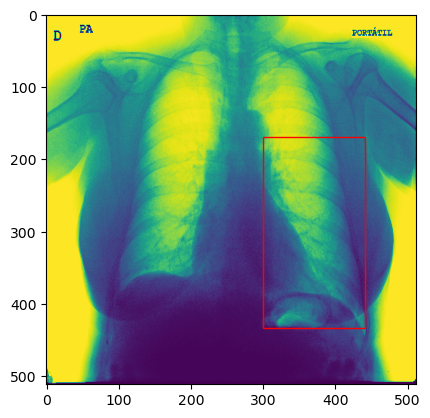

In [37]:
num = 2
image, targets = dataset.__getitem__(num)
image = image.unsqueeze(0)

bench = DetBenchPredict(model)
with torch.no_grad():
    output = bench(image)

fig, ax = pp.subplots()
ax.imshow(image[0,0,:,:])

for i in range(output.shape[1]):
    if output[0,i,4]>0.35:
        x1 = int(output[0, i, 0])
        y1 = int(output[0, i, 1])
        width = int(output[0, i, 2] - output[0, i, 0])
        height = int(output[0, i, 3] - output[0, i, 1])
        rect = patches.Rectangle((x1, y1), width, height, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
pp.show()

In [38]:
output[0,0:5,:]

tensor([[2.9952e+02, 1.6909e+02, 4.4224e+02, 4.3437e+02, 4.7577e-01, 1.0000e+00],
        [1.0472e+02, 2.8194e+02, 2.0541e+02, 4.0401e+02, 3.1404e-01, 1.0000e+00],
        [9.0694e+01, 1.6232e+02, 2.2782e+02, 4.3187e+02, 2.7043e-01, 1.0000e+00],
        [3.0897e+02, 2.2658e+02, 4.2308e+02, 3.9027e+02, 2.4524e-01, 1.0000e+00],
        [3.1618e+02, 2.5585e+02, 4.3226e+02, 4.7373e+02, 2.3821e-01, 1.0000e+00]])

In [39]:
train_image_list.loc[num]['boxes'], train_image_list.loc[num]['classID']

("[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]", 3.0)

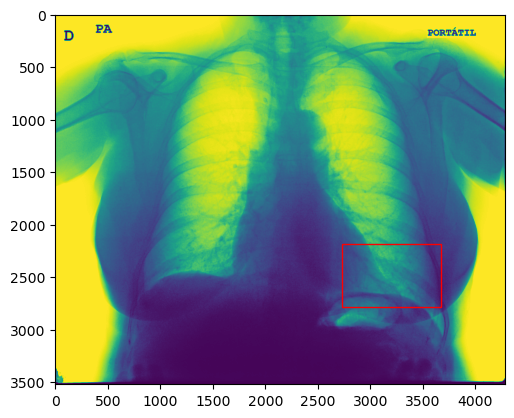

(3520, 4280)

In [40]:
dcm_path = os.path.join(train_root_path,
                        train_image_list['studyID'][num],
                        train_image_list['seriesID'][num],
                        train_image_list['imageID'][num])
dcm = pydicom.dcmread(dcm_path)
image = dcm.pixel_array.astype("float32")

fig, ax = pp.subplots()
ax.imshow(image)

c = np.array([[2729, 2181, 948, 604]])

for i in range(c.shape[0]):
    x1 = c[i,0]
    y1 = c[i,1]
    width = c[i,2]
    height = c[i,3]
    rect = patches.Rectangle((x1, y1), width, height, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

pp.show()
image.shape